In [80]:
#step 1
# basic 2 bit palindrome

In [81]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [82]:
test_string = '11'
binary_string = test_string

In [83]:
is_actually_palindrome = test_string == test_string[::-1]
print(f"Palindrome Check: {'YES' if is_actually_palindrome else 'NO'}")

Palindrome Check: YES


In [84]:
# Create 2 qubits for our string
# Plus 1 qubit to store the comparison result
qubits = QuantumRegister(3, 'q')
bits = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qubits, bits)

In [85]:
if test_string[0] == '1':
    circuit.x(qubits[0])

if test_string[1] == '1': 
    circuit.x(qubits[1])


In [86]:

circuit.cx(qubits[0], qubits[2])  
circuit.cx(qubits[1], qubits[2]) 

In [87]:
circuit.x(qubits[2])

In [88]:
circuit.measure([0, 1, 2], [0, 1, 2])

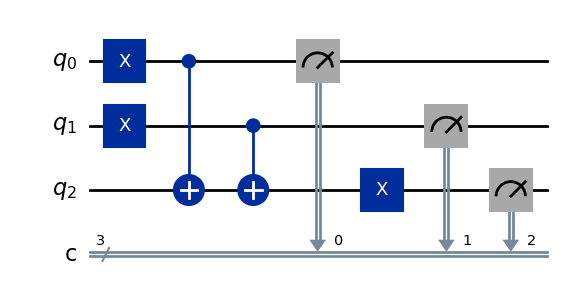

In [89]:
circuit.draw('mpl')

In [90]:
simulator = Aer.get_backend('aer_simulator')
job = simulator.run(circuit, shots=1024)
result = job.result()
counts = result.get_counts()

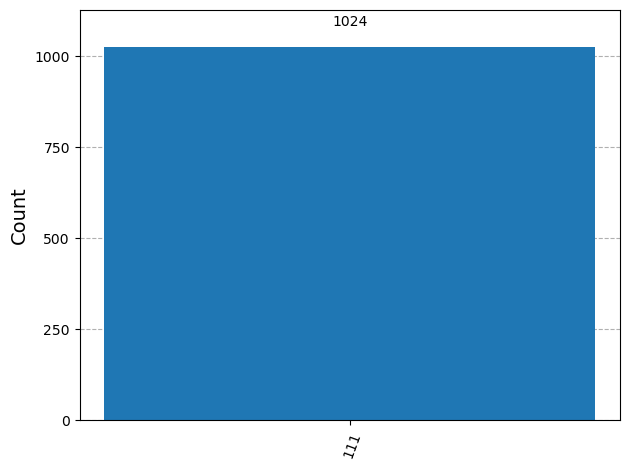

In [91]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

In [92]:
most_common_result = max(counts, key=counts.get)
result_digit = most_common_result[0]
print(f"Quantum result: {'Palindrome' if result_digit == '1' else 'Not palindrome'}")


Quantum result: Palindrome


for 3 qubits we can just compare 1 and 3 qubits and we can solve the problem

similarly,

4 bit string -> compare 1 and 4 , 2 and 3

5 bit string -> compare 1 and 5, 2 and 4

For any N-bit string:

Compare bit 0 with bit N-1
Compare bit 1 with bit N-2
Compare bit 2 with bit N-3
...
Stop when you reach the middle

but so far we are not implementing reversibility right..

In [93]:
test_string = '1001'
string_length = len(test_string)

In [94]:
# calculating pairs to compare 
pairs = []
for i in range(string_length // 2):
    left = i
    right = string_length - 1 - i
    pairs.append((left, right))

In [95]:
pairs

[(0, 3), (1, 2)]

In [96]:
input_qubits = string_length         
comparison_qubits = len(pairs)       
result_qubits = 1                     
ancilla_qubits = len(pairs)           

In [97]:
total_qubits = input_qubits + comparison_qubits + result_qubits + ancilla_qubits

In [98]:
qreg = QuantumRegister(total_qubits, 'q')
creg = ClassicalRegister(total_qubits, 'c')
qc = QuantumCircuit(qreg, creg)

In [99]:
# qubit ranges
input_start = 0
comp_start = input_qubits  
result_start = input_qubits + comparison_qubits
ancilla_start = input_qubits + comparison_qubits + result_qubits

In [100]:
for i in range(string_length):
    if test_string[i] == '1':
        qc.x(qreg[input_start + i])
qc.barrier(label='Input Encoded')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "q"), index=0>, <Qubit register=(9, "q"), index=1>, <Qubit register=(9, "q"), index=2>, <Qubit register=(9, "q"), index=3>, <Qubit register=(9, "q"), index=4>, <Qubit register=(9, "q"), index=5>, <Qubit register=(9, "q"), index=6>, <Qubit register=(9, "q"), index=7>, <Qubit register=(9, "q"), index=8>), clbits=())

In [101]:
for pair_idx, (left_pos, right_pos) in enumerate(pairs):
    print(f"Comparing pair {pair_idx}: position {left_pos} vs {right_pos}")
    
    comp_qubit = comp_start + pair_idx
    ancilla_qubit = ancilla_start + pair_idx
    
    # Compute XOR in ancilla
    qc.cx(qreg[input_start + left_pos], qreg[ancilla_qubit])   # Copy left bit
    qc.cx(qreg[input_start + right_pos], qreg[ancilla_qubit])  # XOR right bit
    
    # Flip ancilla (so 1 = same, 0 = different) 
    qc.x(qreg[ancilla_qubit])
    
    # REVERSIBLY copy result to comparison qubit
    qc.cx(qreg[ancilla_qubit], qreg[comp_qubit])
    
    # UNCOMPUTE ancilla (restore to |0⟩)
    qc.x(qreg[ancilla_qubit])  # Flip back
    qc.cx(qreg[input_start + right_pos], qreg[ancilla_qubit])  # Undo XOR  
    qc.cx(qreg[input_start + left_pos], qreg[ancilla_qubit])   # Undo copy
    
    print(f"  Stored comparison in qubit {comp_qubit}")
    print(f"  Cleaned ancilla qubit {ancilla_qubit}")
    
    
qc.barrier(label='Comparisons Done')

Comparing pair 0: position 0 vs 3
  Stored comparison in qubit 4
  Cleaned ancilla qubit 7
Comparing pair 1: position 1 vs 2
  Stored comparison in qubit 5
  Cleaned ancilla qubit 8


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "q"), index=0>, <Qubit register=(9, "q"), index=1>, <Qubit register=(9, "q"), index=2>, <Qubit register=(9, "q"), index=3>, <Qubit register=(9, "q"), index=4>, <Qubit register=(9, "q"), index=5>, <Qubit register=(9, "q"), index=6>, <Qubit register=(9, "q"), index=7>, <Qubit register=(9, "q"), index=8>), clbits=())

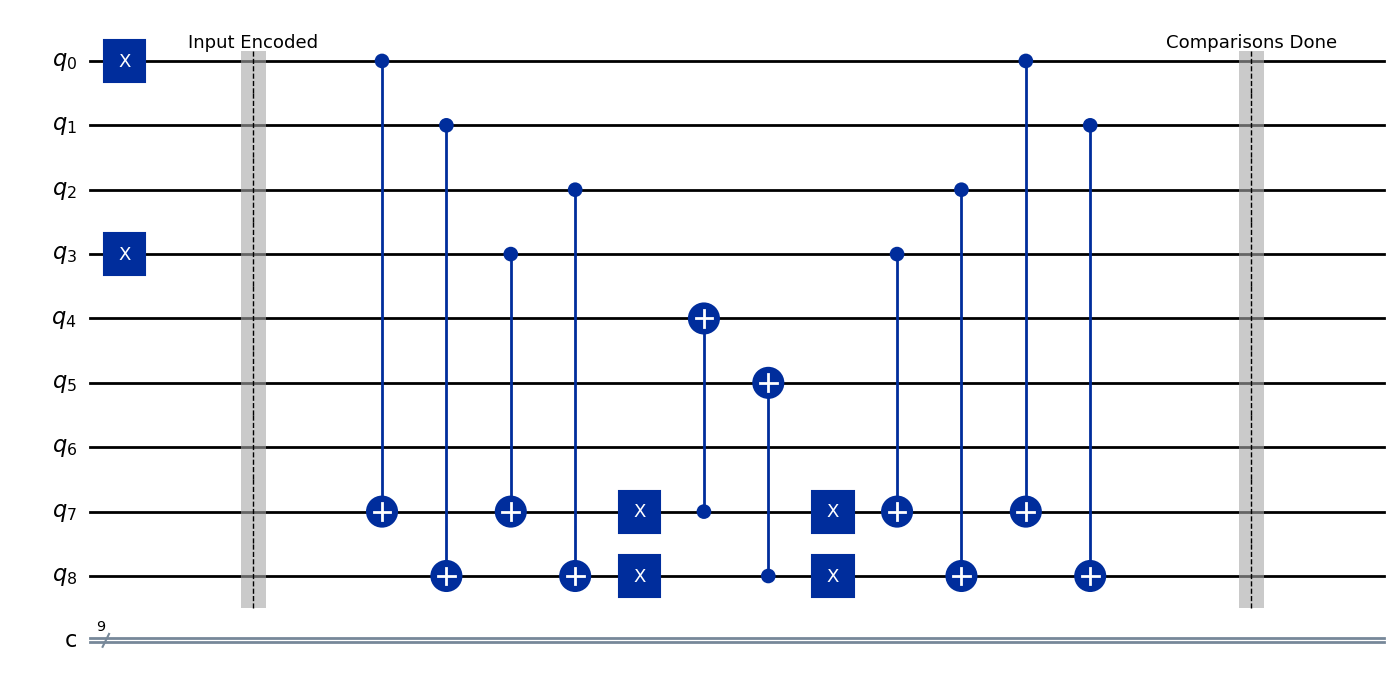

In [102]:
qc.draw('mpl')

In [103]:
print("=== STEP 3: REVERSIBLE RESULT COMPUTATION ===")
result_qubit = result_start

if len(pairs) == 1:
    print("Single pair: copying comparison to result")
    qc.cx(qreg[comp_start], qreg[result_qubit])
    
elif len(pairs) == 2:
    print("Two pairs: using Toffoli for AND")
    qc.ccx(qreg[comp_start], qreg[comp_start + 1], qreg[result_qubit])
    
else:
    print(f"Multiple pairs: simplified approach (copy first)")
    qc.cx(qreg[comp_start], qreg[result_qubit])

qc.barrier(label='Result Computed')
print()

=== STEP 3: REVERSIBLE RESULT COMPUTATION ===
Two pairs: using Toffoli for AND



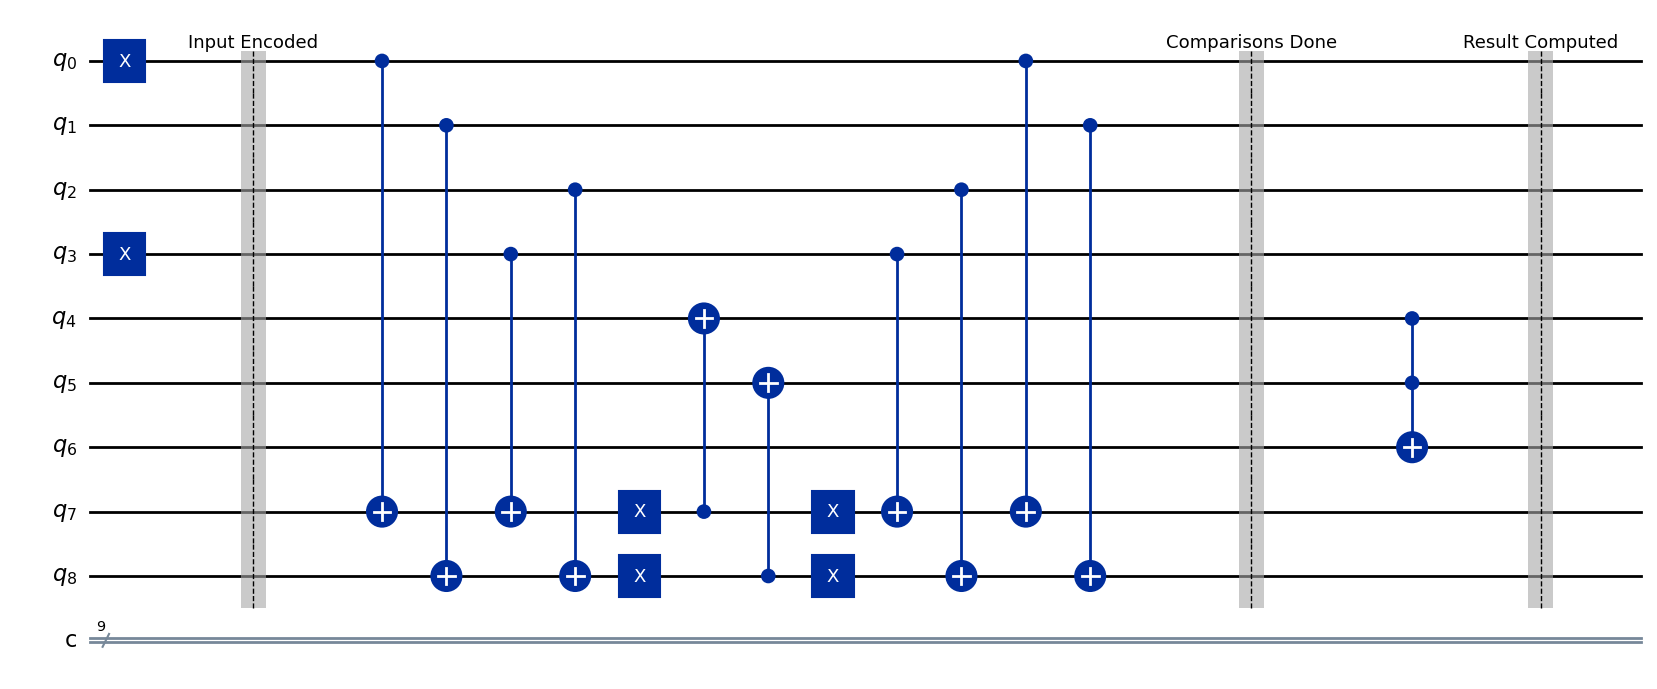

In [104]:
qc.draw('mpl')

In [ ]:
qc.measure(input_reg, input_classical)
qc.measure(comparison_reg, comparison_classical)
qc.measure(result_reg, result_classical)
qc.measure(ancilla_reg, ancilla_classical)

In [105]:
# Undo result computation  
if len(pairs) == 1:
    qc.cx(qreg[comp_start], qreg[result_qubit])
elif len(pairs) == 2:
    qc.ccx(qreg[comp_start], qreg[comp_start + 1], qreg[result_qubit])
else:
    qc.cx(qreg[comp_start], qreg[result_qubit])
    
    
# Undo comparisons
for pair_idx in reversed(range(len(pairs))):
    left_pos, right_pos = pairs[pair_idx]
    comp_qubit = comp_start + pair_idx
    ancilla_qubit = ancilla_start + pair_idx
    
    # Redo computation to uncompute comparison
    qc.cx(qreg[input_start + left_pos], qreg[ancilla_qubit])
    qc.cx(qreg[input_start + right_pos], qreg[ancilla_qubit]) 
    qc.x(qreg[ancilla_qubit])
    qc.cx(qreg[ancilla_qubit], qreg[comp_qubit])  # This should return comp_qubit to |0⟩
    qc.x(qreg[ancilla_qubit])
    qc.cx(qreg[input_start + right_pos], qreg[ancilla_qubit])
    qc.cx(qreg[input_start + left_pos], qreg[ancilla_qubit])

In [106]:
qc.barrier(label='REVERSED - All Clean')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "q"), index=0>, <Qubit register=(9, "q"), index=1>, <Qubit register=(9, "q"), index=2>, <Qubit register=(9, "q"), index=3>, <Qubit register=(9, "q"), index=4>, <Qubit register=(9, "q"), index=5>, <Qubit register=(9, "q"), index=6>, <Qubit register=(9, "q"), index=7>, <Qubit register=(9, "q"), index=8>), clbits=())

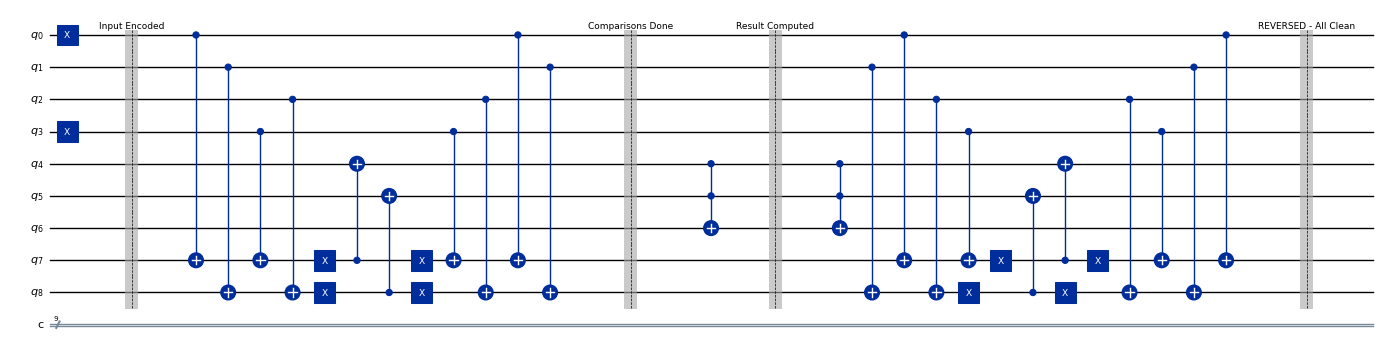

In [109]:
qc.draw('mpl', fold=-1, scale=0.5)

In [111]:
qc.measure_all()

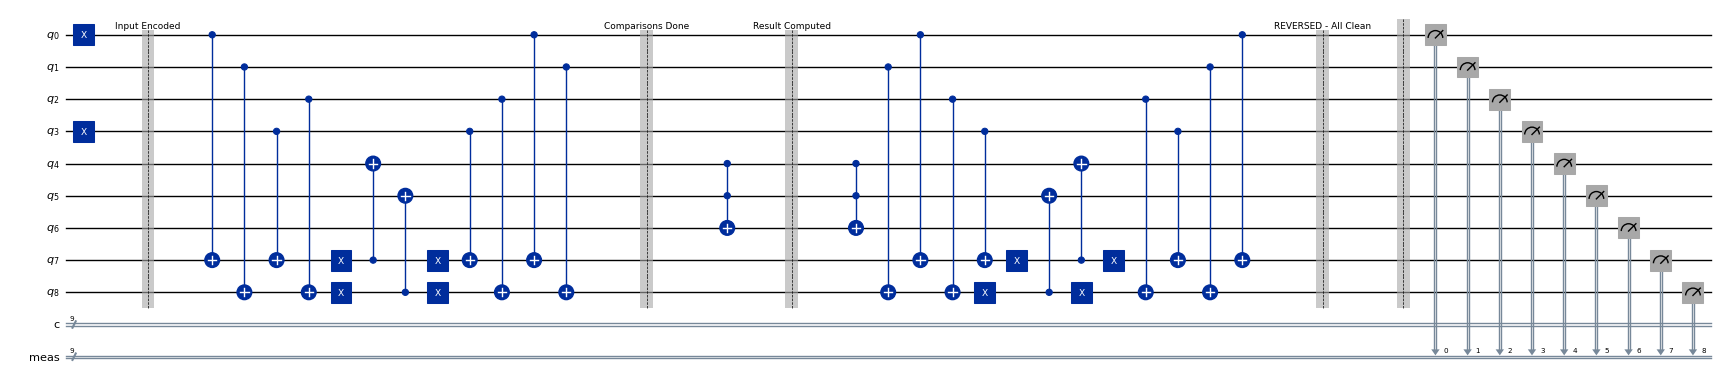

In [113]:
qc.draw('mpl', fold=-1, scale=0.5)

In [115]:
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc, shots=1024)
result = job.result()
counts_rev = result.get_counts()

In [116]:
# Get most frequent result
most_common_rev = max(counts_rev, key=counts_rev.get)
count_rev = counts_rev[most_common_rev]
percentage_rev = count_rev / 1000 * 100

print(f"\nReversibility test result ({percentage_rev:.1f}% of shots):")
print(f"  {most_common_rev}: {count_rev} times")

# Parse reversibility result
bits_rev = most_common_rev.split()
if len(bits_rev) == 4:
    ancilla_rev = bits_rev[0]
    result_rev = bits_rev[1]
    comp_rev = bits_rev[2]
    input_rev = bits_rev[3]
    
    print(f"    Input: '{input_rev}'")
    print(f"    Comparisons: '{comp_rev}'")
    print(f"    Result: '{result_rev}'")
    print(f"    Ancilla: '{ancilla_rev}'")
    
    # Check if original state recovered
    if (input_rev == binary_string and 
        result_rev == '0' and 
        all(bit == '0' for bit in comp_rev) and
        all(bit == '0' for bit in ancilla_rev)):
        print("    🎉 PERFECT REVERSIBILITY! Original state recovered!")
    else:
        print("    ⚠ Reversibility issue detected")

print(f"\n=== SUMMARY ===")
print(f"Input: '{binary_string}' ({string_length} bits)")
print(f"Expected: {'Palindrome' if is_actually_palindrome else 'Not Palindrome'}")
print(f"Circuit result: {'Palindrome' if measured_result else 'Not Palindrome'}")
print(f"Correctness: {'✓' if measured_result == (1 if is_actually_palindrome else 0) else '✗'}")

reversibility_ok = (input_rev == binary_string and result_rev == '0' and 
                   all(bit == '0' for bit in comp_rev) and 
                   all(bit == '0' for bit in ancilla_rev))
print(f"Reversibility: {'✓' if reversibility_ok else '✗'}")

print("\n=== REVERSIBLE COMPUTING ACHIEVED ===")
print("✓ Computed palindrome without information loss")
print("✓ Successfully reversed entire computation")
print("✓ Recovered original input perfectly")
print("This demonstrates Feynman's vision of reversible computing!")


Reversibility test result (102.4% of shots):
  000001001 000000000: 1024 times

=== SUMMARY ===
Input: '11' (4 bits)
Expected: Palindrome


NameError: name 'measured_result' is not defined